## Dissecting Ted
**Computational Analysis of Big Data Final Project**

*Jack Mazanec, Morgan Hogenmiller, Valerie Huang*

**Tags**

In [3]:
from afinn import Afinn
from matplotlib import pyplot as plt

# this is an example on sentiment analysis
afinn = Afinn(emoticons=True)
afinn.score('This is utterly excellent!')

3.0

In [4]:
import pandas as pd

# read in the two csv files
ted_main = pd.read_csv('data/ted_main.csv')
scripts = pd.read_csv('data/transcripts.csv')

# get the column "transcripts" from transcripts.csv
# print how many talks
transcripts = scripts["transcript"]
length = len(transcripts)
print "There are " + str(length) + " talks"

# get list of the senti-scores of first ten talks based on transcripts
scores=[]
for i in range(0, 10):
    talk_score=afinn.score(transcripts[i])
    scores.append(talk_score)
print scores

There are 2467 talks
[163.0, 91.0, 139.0, 130.0, 93.0, 160.0, 119.0, 38.0, 240.0, 184.0]


In [5]:
import datetime

unix_film_dates = ted_main["film_date"]
unix_publish_dates = ted_main["published_date"]

# get list of the readable filmed dates of first ten talks based on unix timestamp
filmDate=[]
for i in range(0, 10):
    real_filmdate=datetime.datetime.fromtimestamp(int(unix_film_dates[i])).strftime('%Y-%m-%d')
    filmDate.append(real_filmdate)
print filmDate

# get list of the readable published dates of first ten talks based on unix timestamp
publishDate=[]
for i in range(0, 10):
    real_publishdate=datetime.datetime.fromtimestamp(int(unix_publish_dates[i])).strftime('%Y-%m-%d')
    publishDate.append(real_publishdate)
print publishDate


['2006-02-25', '2006-02-25', '2006-02-24', '2006-02-26', '2006-02-22', '2006-02-02', '2006-02-24', '2006-02-23', '2006-02-02', '2006-02-25']
['2006-06-27', '2006-06-27', '2006-06-27', '2006-06-27', '2006-06-27', '2006-06-27', '2006-07-10', '2006-07-10', '2006-07-18', '2006-07-18']


## What tags generate the most views?

In this section, we wanted to analyze which tags generally garner the most views. To do this, for each tag, we sum up the amount of views each talk that contains the tag has. Then, we get the average by dividing by the number of talks that use that tag. We print out the 10 highest averages and the corresponding tags and then create a histogram.

In [3]:
## Imports for the whole section
import pandas as pd
from matplotlib import pyplot as plt
import json
import networkx as nx

In [4]:
## Read in data about tags
ted_main = pd.read_csv('data/ted_main.csv')
tags_deets = dict() # Dictionary containing tags as keys and total views, frequency tag is used as values

## Get all tags and their views and freq
# Loop through each talk and get/set tags data
for i in range(len(ted_main)):
    views = int(ted_main['views'][i]) # total views for that talk
    string_tags = [t.strip() for t in ted_main['tags'][i].strip().lower().replace("'", "")[1:-1].split(',')] # Array of tags for that talk
    for tag in string_tags:
        if tag not in tags_deets:
            tags_deets[tag] = {'views':0, 'freq':0, 'avg':0}
        # Set values for that tag
        tags_deets[tag]['views'] += views
        tags_deets[tag]['freq'] += 1

## Get average values for all tags *regardless of frequency*
tag_avg = {k:tags_deets[k]['views']/float(tags_deets[k]['freq']) for k in tags_deets.keys()}        

In [5]:
## Get top 10 averages of all keys
top_views = list()
for key, value in sorted(tag_avg.iteritems(), key=lambda (k,v): (v,k)):
    top_views.append([key, value])
top_views.reverse()
## Print out results
print "Tags with highest average views\n"
for i, (key, value) in enumerate(top_views):
    if i > 9: break
    print str(i+1) + ".) " + key + ": " + str(round(value, 2))

Tags with highest average views

1.) body language: 7993455.09
2.) testing: 6657858.0
3.) success: 6454556.61
4.) introvert: 6303975.6
5.) mindfulness: 4335876.6
6.) evil: 4283967.0
7.) dance: 4122717.16
8.) productivity: 4048263.35
9.) addiction: 4033930.2
10.) magic: 4021694.06


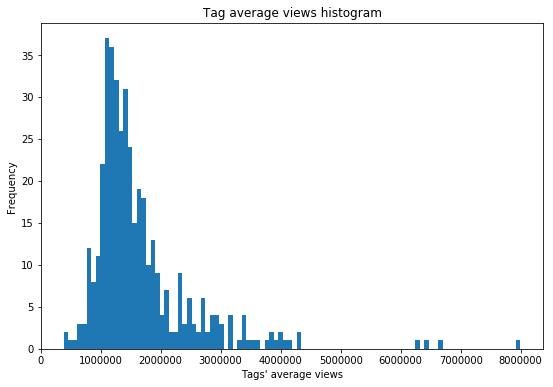

In [6]:
## Create histogram for the data
top_view_values = [top_views[i][1] for i in range(len(top_views))]
plt.figure(figsize=(9, 6))
plt.hist(top_view_values, 100)
plt.xlabel("Tags' average views")
plt.ylabel("Frequency")
plt.title("Tag average views histogram")
plt.show()

As can be seen in the histogram, the distribution is skewed right. Most tags have an average views in between 500,000 and 2,500,000. There are some outliers that have significantly more than this.

Next, we wanted to see if the distribution would be different if we required that, to be included in the distribution, a tag needed to be used in at least 5 talks.

In [7]:
## Filter for tags that have a minimum of 5 different speeches
top_views_filtered = list()
filter_value = 5
for key, value in top_views:
    if tags_deets[key]['freq'] < filter_value: continue
    top_views_filtered.append([key, value])
## Print out results
print "Tags with highest average views with at least " + str(filter_value) + " tag instances\n"
for i, (key, value) in enumerate(top_views_filtered):
    if i > 9: break
    print str(i+1) + ".) " + key + ": " + str(round(value, 2))

Tags with highest average views with at least 5 tag instances

1.) body language: 7993455.09
2.) success: 6454556.61
3.) introvert: 6303975.6
4.) mindfulness: 4335876.6
5.) dance: 4122717.16
6.) productivity: 4048263.35
7.) addiction: 4033930.2
8.) magic: 4021694.06
9.) time: 3893878.59
10.) work-life balance: 3873959.5


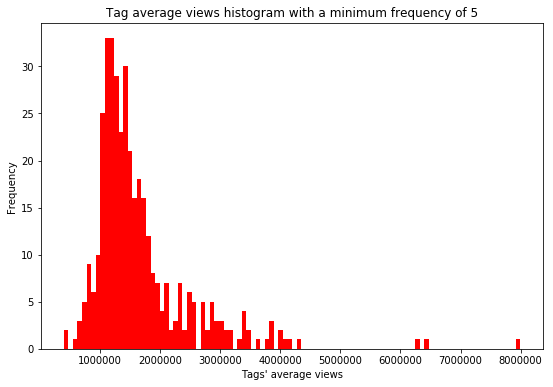

In [8]:
## Create another histogram
top_view_values_filtered = [top_views_filtered[i][1] for i in range(len(top_views_filtered))]
plt.figure(figsize=(9, 6))
plt.hist(top_view_values_filtered, 100, color="red")
plt.xlabel("Tags' average views")
plt.ylabel("Frequency")
plt.title("Tag average views histogram with a minimum frequency of " + str(filter_value))
plt.show()

As can be seen, a few tags are removed from the top 10, but the overall distribution looks very similar to the distribution in the earlier histogram.

## How are tags connected? 

Next, we wanted to see how tags are connected together. To do this, we created a graph where each node is a tag and the edges are connections between the tags that have been used in the same talk.

Graph quick statistics
    Total nodes: 416
    Total edges: 22149
    Avg edge/node: 53.24


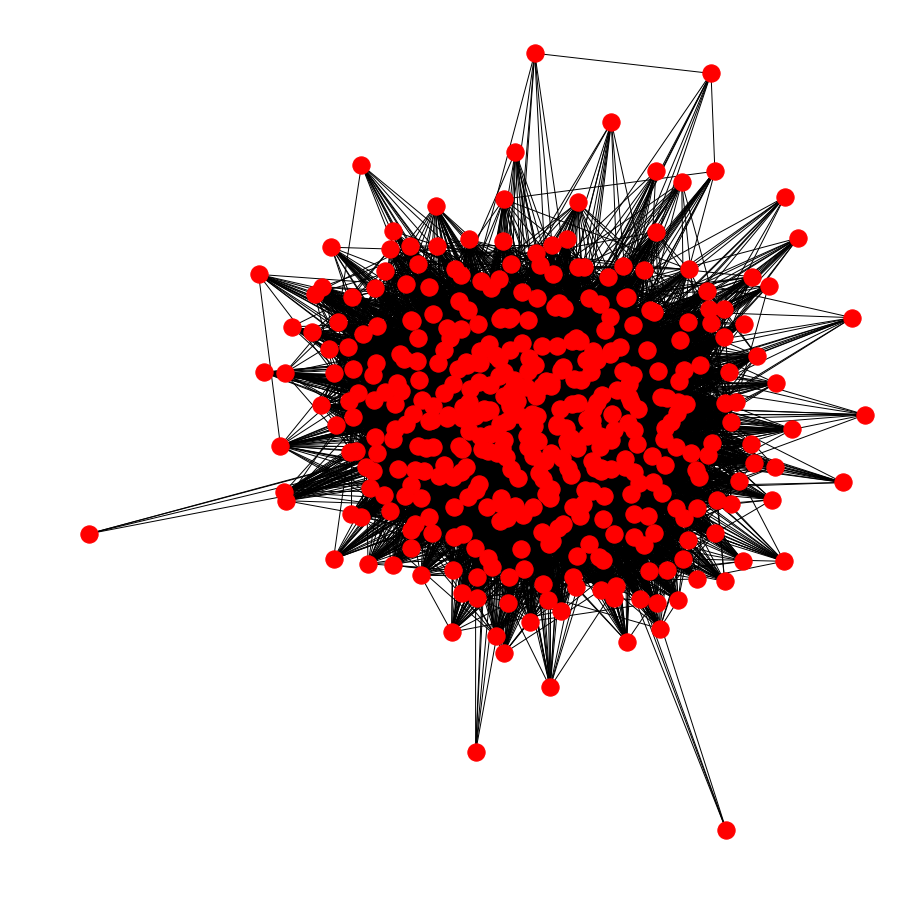

In [9]:
## Create network connecting tags
# an individual tag will be the nodes
# the edges will connect nodes if they appear in the same talk
tag_graph = nx.Graph()
# Make all nodes and then add edges
for i in range(len(ted_main)):
    # Properly format all tags from that talk into an array
    string_tags = [t.strip() for t in ted_main['tags'][i].strip().lower().replace("'", "")[1:-1].split(',')] # Array of tags for that talk
    # Add all tags as nodes to the graph
    tag_graph.add_nodes_from(string_tags)
    # Add edges for each tag to every other tag in that group
    for tag in string_tags:
        edges = [(tag, t) for t in string_tags if t != tag]
        tag_graph.add_edges_from(edges)
# Print stats about graph
print "Graph quick statistics"
print "    Total nodes: " + str(len(tag_graph.nodes))
print "    Total edges: " + str(len(tag_graph.edges))
print "    Avg edge/node: " + str(round(float(len(tag_graph.edges))/len(tag_graph.nodes), 2))

# Plot graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(tag_graph)
nx.draw(tag_graph, pos=pos)
plt.show()

In [10]:
## Print most connected tags out
top = 10
new_graph = list(reversed(sorted([(v,t) for t,v in nx.degree(tag_graph)])))
print "Most connected tags\n"
for i in range(top):
    print str(i+1) + ".) " + new_graph[i][1] + ": " + str(new_graph[i][0])

Most connected tags

1.) technology: 370
2.) tedx: 365
3.) science: 354
4.) innovation: 335
5.) global issues: 335
6.) society: 316
7.) culture: 316
8.) collaboration: 312
9.) future: 311
10.) humanity: 305


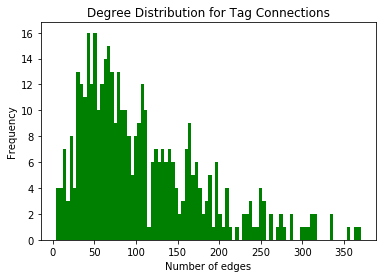

In [11]:
## Print out distribution of edges for hub detection
connections = [t[1] for t in nx.degree(tag_graph)]
plt.hist(connections, 90, color="green")
plt.title("Degree Distribution for Tag Connections")
plt.ylabel("Frequency")
plt.xlabel("Number of edges")
plt.show()

As can be seen from this histogram and the earlier printed out statistics, there are some tags that are significantly more connected than the average tag. From looking at the top 10, these tags are very general. For instance, the top most connected tag is technology.

## Is there a formula for getting the most views?

In this section, we wanted to build a model that would take a description of a talk and predict how many views it would get. To do this, we created a bag of words matrix from all the existing descriptions and used Lasso regression to create the model. Lasso regression is a regression analysis model that selects variables and performs regularization to maximize prediction accuracy.

In [1]:
import nltk
import pandas as pd
import numpy as np
# First get a list of all words in all descriptions that aren't stop words
stopwords = nltk.corpus.stopwords.words('english') 
ted_main = pd.read_csv('data/ted_main.csv')
all_words = set()
for i in range(len(ted_main)):
    talk_descript = [x for x in ted_main['description'][i].replace('(', '').replace(')', '').split(' ') if x != '']
    for word in talk_descript:
        if word.decode('utf-8') in stopwords:
            continue
        else:
            all_words.add(word)
# Convert to list
all_words = list(all_words)

In [2]:
# Construct np array to keep track of bag of words
views = list()
bag_of_words = np.zeros([len(ted_main), len(all_words)]) # last column is the views
# Loop through each speech and add up the words and get the views
for i in range(len(ted_main)):
    views.append(ted_main['views'][i])
    talk_descript = [x for x in ted_main['description'][i].replace('(', '').replace(')', '').split(' ') if x != '']
    for j, word in enumerate(all_words):
        bag_of_words[i][j] = talk_descript.count(word)

In [4]:
from sklearn import linear_model
# Do a Lasso regression with number of views
clf = linear_model.Lasso(alpha=0.1)
c = clf.fit(bag_of_words, views)

In [5]:
Rsquare = clf.score(bag_of_words, views)
print Rsquare

0.999999992387989


In [1]:
# Allow for input from user
t = raw_input('Enter a description for your talk: ').rstrip().replace('(', '').replace(')', '').split(' ')
X = [list()]
for j, word in enumerate(all_words):
    X[0].append(t.count(word))
print "A talk with this description would get an estimated " + str(int(clf.predict(X))) + " views!"

KeyboardInterrupt: 

## How can we help recommend talks for users based on their interests?

** Recommender System **

Before creating our reccomentation system, we decided to test how tags on their own could help suggest talks. Below we create a function that allows you to choose a tag that interests you from a word cloud of all of the tags in the dataset. You also have the option to choose more than one tag if a specific combination interests you. From the fuction, we will return to you TED talks that pertain to the topic(s) that you chose. Our methodology involves finding the talks which contain the tags or combination of tags that you chose. The list of recommended TED talks for you will be sorted by popularity, and we will provide statistics (title, desription, & popularity) about each talk for you as well. The next part of our recommendation design will make an even stronger prediction by searching within the texts of the talks to find which talks pertain most to your desired tags.

In [10]:
import pandas as pd
import re
import os
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
transcripts = pd.read_csv("data/transcripts.csv")
ted_data= pd.read_csv("data/ted_main.csv")
ted= pd.merge(transcripts, ted_data, on='url')
ted.to_csv('ted_33.csv', sep='\t', encoding='utf-8')

Word Cloud of All Tags


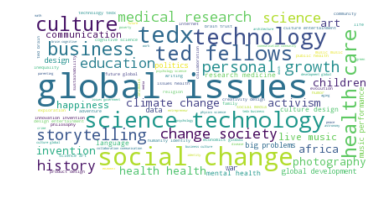

In [11]:
tags= ted.loc[:, "tags"]

#Clean tags for word cloud
all_tags = []
for tag in tags:
    tag=tag.lower()
    tag=re.sub("[^A-Za-z0-9]+"," ",tag)
    tag=re.sub("[^\w ]","",tag)
    tag=tag.split(",")
    all_tags.extend(tag)
    
    
all_tags=str(all_tags)

#Create word cloud
tags_wordcloud = WordCloud(background_color='white'
                         ).generate(all_tags)
plt.figure()
plt.imshow(tags_wordcloud, interpolation="bilinear")
plt.axis("off")
print('Word Cloud of All Tags')
plt.show()

In [12]:
#make a counter for the number of times that the tag is said 
def recommend_talk(tag1,tag2,tag3):
    pd.set_option('display.max_colwidth', -1)
    if tag2 == "" and tag3 == "":
        recs1= ted[ted['tags'].str.contains(tag1)].sort_values(by = ["views"], ascending=False)
        recs1= recs1.set_index('title')
        return recs1.loc[:,['description','tags','views']]
    if tag3 == "":    
        recs2= ted[ted['tags'].str.contains(tag1) & ted['tags'].str.contains(tag2)].sort_values(by = ["views"], ascending=False)
        recs2= recs2.set_index('title')
        return recs2.loc[:,['description','tags','views']]
    else:
        recs3= ted[ted['tags'].str.contains(tag1) & ted['tags'].str.contains(tag2) & ted['tags'].str.contains(tag3)].sort_values(by = ["views"], ascending=False)
        recs3= recs3.set_index('title')
        return recs3.loc[:,['title','description','tags','views']]
    


recommend_talk('technology','music', '')

,description,tags,views
title,,,
The magic of truth and lies (and iPods),"Using three iPods like magical props, Marco Tempest spins a clever, surprisingly heartfelt meditation on truth and lies, art and emotion.","['art', 'design', 'entertainment', 'illusion', 'magic', 'music', 'technology']",5447236
"Thoughts on humanity, fame and love","""I sell dreams, and I peddle love to millions of people,"" says Shah Rukh Khan, Bollywood's biggest star. In this charming, funny talk, Khan traces the arc of his life, showcases a few of his famous dance moves and shares hard-earned wisdom from a life spent in the spotlight.","['aging', 'art', 'communication', 'dance', 'entertainment', 'family', 'future', 'happiness', 'humanity', 'india', 'love', 'movies', 'music', 'personal growth', 'success', 'technology']",4642478
"Robots with ""soul""","What kind of robots does an animator / jazz musician / roboticist make? Playful, reactive, curious ones. Guy Hoffman shows demo film of his family of unusual robots -- including two musical bots that like to jam with humans.","['AI', 'TEDx', 'entertainment', 'jazz', 'music', 'robots', 'technology']",2931366
I listen to color,"Artist Neil Harbisson was born completely color blind, but these days a device attached to his head turns color into audible frequencies. Instead of seeing a world in grayscale, Harbisson can hear a symphony of color -- and yes, even listen to faces and paintings.","['Senses', 'art', 'cyborg', 'design', 'entertainment', 'innovation', 'music', 'prosthetics', 'sound', 'technology']",2468887
The polyphonic me,"Frustrated by not being able to sing two notes at the same time, musical inventor Beardyman built a machine to allow him to create loops and layers from just the sounds he makes with his voice. Given that he can effortlessly conjure the sound of everything from crying babies to buzzing flies, not to mention mimic pretty much any musical instrument imaginable, that's a lot of different sounds. Sit back and let the wall of sound of this dazzling performance wash over you.","['creativity', 'entertainment', 'music', 'technology']",2067955
My web playroom,"On the web, a new ""Friend"" may be just a click away, but true connection is harder to find and express. Ze Frank presents a medley of zany Internet toys that require deep participation -- and reward it with something more nourishing. You're invited, if you promise you'll share.","['Internet', 'comedy', 'gaming', 'humanity', 'humor', 'music', 'play', 'technology', 'web']",1876053
Toy tiles that talk to each other,"MIT grad student David Merrill demos Siftables -- cookie-sized, computerized tiles you can stack and shuffle in your hands. These future-toys can do math, play music, and talk to their friends, too. Is this the next thing in hands-on learning?","['art', 'business', 'children', 'computers', 'design', 'education', 'invention', 'music', 'technology', 'toy']",1765153
The untouchable music of the theremin,"Virtuoso Pamelia Kurstin performs and discusses her theremin, the not-just-for-sci-fi electronic instrument that is played without being touched. Songs include ""Autumn Leaves,"" ""Lush Life"" and David Mash’s ""Listen, Words Are Gone.""","['live music', 'music', 'performance', 'technology']",1687185
Simplicity sells,"New York Times columnist David Pogue takes aim at technology’s worst interface-design offenders, and provides encouraging examples of products that get it right. To funny things up, he bursts into song.","['computers', 'entertainment', 'interface design', 'media', 'music', 'performance', 'simplicity', 'software', 'technology']",1636292


In this section, we wanted to create a simple recommendation system where users could get suggested talks based on what talks they have liked, what topics they want to hear and what other people have thought about the talks. The list of recommendations is in a python dictionary that is used as a priority queue. Each title has 3 values. The first corresponds to whether or not the listener has liked or disliked a speech that is related to that speech and what tags the user has indicicated that they want to listen to. The second column is a summation of the ratings sentiment scores. Using the python sort method, we are able to sort based first on the first column, and then on the second column.

In [21]:
#!/usr/bin/env python2.7
import pandas as pd
import ast # converts string to dict
from afinn import Afinn # Sentiment score
import sys
'''
How we're going to rate recommendations:
1. Likes and dislikes on similar talks ~ everyone starts out with 0
2. get sentiment score on each rating and multiply it by the number of ratings
Keep track of speeches that have already been recommended and change ratings 
based on ratings of similar talks
'''

## Initialize dictionary for all talks
# Reads in all talks and scores their ratings
def init():
    ## Get tags user may want to listen to before
    user_tags = raw_input("Enter tags to describe the kinds of speeches you want to listen to: ").rstrip().lower().split(' ')
    ## Read in data about tags
    ted_main = pd.read_csv('data/ted_main.csv')
    pq = dict()
    afinn = Afinn()
    ## Get all tags and their views and freq
    # Loop through each talk and get/set tags data
    for i in range(len(ted_main)):
        ratings =  ast.literal_eval(ted_main['ratings'][i])
        title = ted_main['title'][i]
        # Add user input to the order
        t_score = 0
        for t in user_tags:
            if t in ted_main['tags'][i]:
                t_score += 1
        # Get the sentiment score for all the ratings and multiply it by the number of times its said
        r_score = 0
        for rating in ratings:
            r_score += afinn.score(rating['name']) * rating['count']
        pq[title] = [t_score, r_score, 0]
    return pq

## Converts the dictionary of talks into a sorted list of just the titles
def get_list(pq_dict):
    pq = list()
    for key in pq_dict:
        pq.append([pq_dict[key][0], pq_dict[key][1], key])
    pq.sort(reverse=True)
    return [p[2] for p in pq]

## Set up dictionary of related talks
def set_related_talks():
    ## Read in data about tags
    ted_main = pd.read_csv('data/ted_main.csv')
    related_talks = dict()
    ## Get all tags and their views and freq
    # Loop through each talk and get/set tags data
    for i in range(len(ted_main)):  
        titles = [talk['title'] for talk in ast.literal_eval(ted_main['related_talks'][i])]
        related_talks[ted_main['title'][i]] = titles
    return related_talks

## Main execution block
def main():
    ## Init the priority queue, it'll come sorted
    pq_talks = init()
    related_talks = set_related_talks()
    pq_list = get_list(pq_talks)
    ## Read input
    # Continue to loop until everything is gone
    while True:
        while True:
            print "Enter 0 for the next rec\nEnter 1 to rate a Ted talk"
            inp = input()
            if inp == 0 or inp == 1:
                break
        # React to users choice
        if inp == 0:
            # Find first recommendation that hasnt already been rec'd
            index = 0
            for i in range(len(pq_talks)):
                if pq_talks[pq_list[i]][2] == 0:
                    index = i
                    break
            print "We recommend you listen to '" + pq_list[index] + "'"
            # Mark title as recommended
            pq_talks[pq_list[index]][2] = 1
            # Get user feedback
            while True:
                print "Do you want to listen to this? Enter 1 for yes, Enter -1 for no"
                rating = input()
                if rating == -1 or rating == 1:
                    break
            # Update that talks rating
            pq_talks[pq_list[index]][0] += rating
            # Now update rating for all of its related talks
            for talk in related_talks[pq_list[index]]:
                pq_talks[talk][0] += rating
        else:
            # Get rating for a speech the user already listened to
            print "Enter the title of the talk:"
            talk = raw_input().rstrip()
            # Validity check
            while talk not in pq_talks:
                print "Talk not found"
                talk = raw_input().rstrip()
            print "Did you like it? Enter 1 for yes, Enter -1 for no"
            rating = input()
            while rating != -1 and rating != 1:
                print "Error try again"
                rating = input()
            # Update rating and mark as listened to
            pq_talks[talk][2] = 1
            pq_talks[talk][0] += rating
            # Now flag all of its related talks here
            for t in related_talks[talk]:
                pq_talks[t][0] += rating
        # Reset list with updated information
        pq_list = get_list(pq_talks)

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        pass

Enter tags to describe the kinds of speeches you want to listen to: Music
Enter 0 for the next rec
Enter 1 to rate a Ted talk
0
We recommend you listen to 'The transformative power of classical music'
Do you want to listen to this? Enter 1 for yes, Enter -1 for no


## What does word similarity have to do with our interest in TED talks?

This question was inspired by a simple plot that I crated in the exploratory analysis phase of this project. I created the graph below in order to see if the amount of views that a video accumulated correlated at all to the number of comments that the video received. Overall, there seemed to be no linear realtionship between the number of views and the number of comments a video collected. Interestingly, I found an outlier in number of comments that corresponded to a relatively low view count. This inspired me to research the title of this video with the highest comment count. The title was Militant Atheism, and after going a bit further and reserching the titles of the videos with the top 3 numbers of comments, I found that there was a pattern between this title and the other titles: Do Schools Kill Creativity and Science Can Answer Moral Questions. They all contained strange combinations of subjects. Military and religion, school and killing, and science and morality. This motivated me to analyze the effect that unseemingly conpatible topics have on viewers’ response rates and view rates. I came up with the questions from here of, What topics start conversations? And do strange conversations appeal to us? Should more videos be made with such interests in mind?

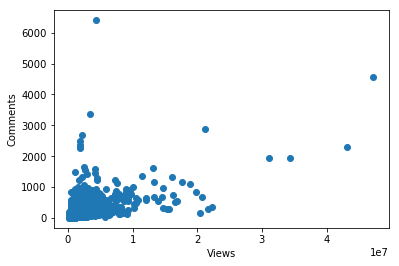

In [14]:
# make a scatter plot with comments and views on the x and y 
plt.scatter(ted.loc[:,"views"],ted.loc[:,"comments"])
plt.xlabel("Views")
plt.ylabel("Comments")
plt.show()

In [16]:
#Titles of the videos with the most comments
#What gets people talking?
sort_comments = ted.sort_values(by = ["comments"], ascending= False)
sort_comments.head(3).loc[:,["title","views", "comments"]].sort_values(by = ["comments"], ascending=False)

,title,views,comments
95,Militant atheism,4374792,6404
0,Do schools kill creativity?,47227110,4553
619,Science can answer moral questions,3433437,3356


To begin to understand the distribution of the similarity between words in titles and their comment counts, I called upon Word2Vec word embedding. Word2vec is a smart, pre-trained method that uses a large neural network representing words in a massive vector to learn inforamation about the relationships between the words. I wanted to train this model on the titles in our TED dataset to learn about the similarity between words in each one.

In [19]:
# breaking titles into readable sentences for the word2vec model
tits= ted.loc[:, "title"]
sentence=[]
for title in tits:
    title=re.sub(":","",title)
    title=re.sub("\?","",title)
    title=re.sub("\-","",title)
    title=title.split()
    sentence.append(title)

In [41]:
#training model on titles
import gensim
from gensim.models import word2vec
import os
import logging
from gensim.models import KeyedVectors
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model = gensim.models.Word2Vec(sentence, min_count=1, hs=1)

2018-05-02 18:15:55,994 : INFO : collecting all words and their counts
2018-05-02 18:15:55,996 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-02 18:15:56,002 : INFO : collected 4493 word types from a corpus of 15383 raw words and 2467 sentences
2018-05-02 18:15:56,003 : INFO : Loading a fresh vocabulary
2018-05-02 18:15:56,014 : INFO : min_count=1 retains 4493 unique words (100% of original 4493, drops 0)
2018-05-02 18:15:56,015 : INFO : min_count=1 leaves 15383 word corpus (100% of original 15383, drops 0)
2018-05-02 18:15:56,029 : INFO : deleting the raw counts dictionary of 4493 items
2018-05-02 18:15:56,030 : INFO : sample=0.001 downsamples 34 most-common words
2018-05-02 18:15:56,031 : INFO : downsampling leaves estimated 12236 word corpus (79.5% of prior 15383)
2018-05-02 18:15:56,036 : INFO : constructing a huffman tree from 4493 words
2018-05-02 18:15:56,293 : INFO : built huffman tree with maximum node depth 14
2018-05-02 18:15:56,301 : INFO

After I trainind the Word2Vec on the titles, I created a measurement using the similariy function from Word2vec to represent the average similarity score of the words in each title. I made a one column table with this measurement for each title, concatenated the table to the main TED dataset, and from there was able to analyze the word similarity score for each title in comparison to the talk's number of comments and number of views.

In [21]:
#Creating a score for each title that represents the average similarity between all of the words in the title
grand_list=[]
for item in sentence:
    if len(item)== 1:
        print(item)
        grand_list.append(1)
    if len(item) == 2:
        print((model.similarity(item[0],item[1])),item)
        grand_list.append((model.similarity(item[0],item[1])))
    elif len(item) ==3:
        print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]))/2,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]))/2)
    elif len(item) ==4:
        print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]))/3,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]))/3)
    elif len(item) ==5:
        #print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]))/4,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]))/4)
    elif len(item) ==6:
        #print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5]))/5,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5]))/5)
    elif len(item) ==7:
        #print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]))/6,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]))/6)
    elif len(item) ==8:
        #print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]))/7,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]))/7)
    elif len(item) ==9:
        #print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]))/8,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]))/8)
    elif len(item) ==10:
        #print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]))/9,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]))/9)
    elif len(item) ==11:
        #print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]) + model.similarity(item[9],item[10]))/10,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]) + model.similarity(item[9],item[10]))/10)
    elif len(item) ==12:
        #print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]) +  model.similarity(item[9],item[10]) +model.similarity(item[10],item[11]))/11,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]) +  model.similarity(item[9],item[10]) +model.similarity(item[10],item[11]))/11)
    elif len(item) ==13:
        #print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]) +  model.similarity(item[9],item[10]) + model.similarity(item[10],item[11]) + model.similarity(item[11],item[12]))/12,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]) +  model.similarity(item[9],item[10]) + model.similarity(item[10],item[11]) + model.similarity(item[11],item[12]))/12)
    elif len(item) ==14:
        #print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]) +  model.similarity(item[9],item[10]) + model.similarity(item[10],item[11]) + model.similarity(item[11],item[12]) + model.similarity(item[12],item[13]))/13,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]) +  model.similarity(item[9],item[10]) + model.similarity(item[10],item[11]) + model.similarity(item[11],item[12]) + model.similarity(item[12],item[13]))/13)
    elif len(item) ==15:
        #print((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]) +  model.similarity(item[9],item[10]) + model.similarity(item[10],item[11]) + model.similarity(item[11],item[12]) + model.similarity(item[12],item[13]) + model.similarity(item[13],item[14]))/14,item)
        grand_list.append((model.similarity(item[0],item[1]) + model.similarity(item[1],item[2]) + model.similarity(item[2],item[3]) + model.similarity(item[3],item[4]) + model.similarity(item[4],item[5])+ model.similarity(item[5],item[6]) + model.similarity(item[6],item[7]) + model.similarity(item[7],item[8]) + model.similarity(item[8],item[9]) +  model.similarity(item[9],item[10]) + model.similarity(item[10],item[11]) + model.similarity(item[11],item[12]) + model.similarity(item[12],item[13]) + model.similarity(item[13],item[14]))/14)       
#keep going until you get all of the titles and then find out about the commments for each one

/Users/morganhogenmiller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  del sys.path[0]
/Users/morganhogenmiller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
/Users/morganhogenmiller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys
/Users/morganhogenmiller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
/Users/morganhogenmiller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `s

0.8975825059493813 ['Do', 'schools', 'kill', 'creativity']
0.8683391267195265 ['Averting', 'the', 'climate', 'crisis']
0.5185559522936204 ['Simplicity', 'sells']
0.5229408719235161 ['Greening', 'the', 'ghetto']
0.881461697934645 ['Letting', 'go', 'of', 'God']
0.3743243767356537 ['A', 'life', 'of', 'purpose']
0.8376969428619452 ['One', 'Laptop', 'per', 'Child']
0.43906492850026607 ['An', "11yearold's", 'magical', 'violin']
0.7632317421545896 ['The', 'birth', 'of', 'Wikipedia']
0.6670493359689119 ['Nerdcore', 'comedy']
0.5795545054497154 ['The', 'paradox', 'of', 'choice']
0.7306633391440613 ['How', 'technology', 'evolves']
0.9559567477498794 ['8', 'secrets', 'of', 'success']
0.09500310682071467 ['Dreams', 'from', 'endangered', 'cultures']
0.1296643395422372 ['Photos', 'of', 'endangered', 'cultures']
0.06556684179870692 ['Four', 'American', 'characters']
0.18058252768138722 ['Everyday', 'inventions']
0.7647360167922409 ['In', 'praise', 'of', 'slowness']
0.79717787645721 ['My', 'wish', 'Re

0.9850203984746605 ['When', 'ideas', 'have', 'sex']
0.9215751670337792 ['Listening', 'to', 'global', 'voices']
0.8185343394035284 ['The', 'politics', 'of', 'fiction']
0.9444479472428599 ['Superheroes', 'inspired', 'by', 'Islam']
0.964772605556116 ['The', 'art', 'of', 'choosing']
0.7672063388739586 ['Wiring', 'an', 'interactive', 'ocean']
0.9222161783681461 ['My', 'mindshifting', 'Everest', 'swim']
0.156959198797211 ['Our', "century's", 'greatest', 'injustice']
0.8617950158293007 ['The', 'Happy', 'Planet', 'Index']
0.7689273426939869 ['The', 'childdriven', 'education']
0.7184664648717125 ['An', 'independent', 'diplomat']
0.6855191096991022 ['Hurdygurdy', 'for', 'beginners']
0.0049657344547636845 ['The', 'quantified', 'self']
0.9005010462951711 ['I', 'am', 'my', 'connectome']
0.8745620131701736 ['An', 'economic', 'reality', 'check']
0.7712423313762168 ["Haiti's", 'disaster', 'of', 'engineering']
0.3948571248425232 ['My', 'web', 'playroom']
0.4456041981776065 ['Poverty,', 'money', 'and', 

/Users/morganhogenmiller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
/Users/morganhogenmiller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
/Users/morganhogenmiller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
/Users/morganhogenmiller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


 ['Mining', 'minerals', 'from', 'seawater']
0.7303868382621412 ['Design,', 'explained.']
0.5037518922616261 ['We', 'are', 'all', 'designers']
0.7469549788454591 ['Archaeology', 'from', 'space']
0.3450575476928209 ['Are', 'we', 'overmedicalized']
0.8138688803535754 ['The', '100,000student', 'classroom']
0.9683272380908997 ["India's", 'invisible', 'innovation']
0.9452054648736178 ['Reinventing', 'the', 'encyclopedia', 'game']
0.4464465218770872 ['The', 'levitating', 'superconductor']
-0.22102021581826467 ["What's", 'your', '200year', 'plan']
0.8620762073593169 ['Meet', 'your', 'microbes']
-0.20278540433584988 ['I', 'listen', 'to', 'color']
0.1329770594067957 ['Building', 'unimaginable', 'shapes']
0.9551578523858817 ['(Re)touching', 'lives', 'through', 'photos']
0.787978486021919 ['Fighting', 'with', 'nonviolence']
0.13547561785128837 ['Dare', 'to', 'disagree']
0.042086239056945474 ['Embrace', 'the', 'remix']
0.80334907384656 ['A', 'thousand', 'times', 'no']
0.9931141362950751 ['Making', 

/Users/morganhogenmiller/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


In [23]:
#Making sure that the length of the average similarity scores is the same as the length of titles
print(len(grand_list))

2467


In [24]:
#Creates pandas dataframs with one column for each title's similarity score
sim_score =  pd.DataFrame(grand_list)
sim_score.columns = ['Similarity Score']

In [27]:
#Concatinates the two dataframes and pulls only relevant information for answering our question
result1 = pd.concat([ted, sim_score], axis=1, join='inner')
sim_focused=result1.loc[:, ["title","Similarity Score","comments","views"]]

This histogram shows the distribution of the similarity scores of the titles. The scores are calculated using a cosine wave and therefore, they range from -1 to 1. The similarity score is the dot product of the two normalized vectors (words) that are compared.

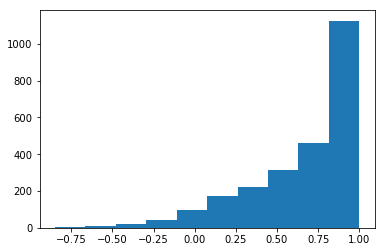

In [28]:
#Histogram that shows the distribution of similarity scores
import numpy as np
import decimal
import matplotlib.pyplot as plt
plt.hist(sim_focused.loc[:,'Similarity Score'])
plt.show()

Interestingly, in contrast to my observations about the similarity of words in the videos with the top three comments, my analysis using Word2vec shows that there seems to be an increase in comments as the similarity in the words in titles rises.

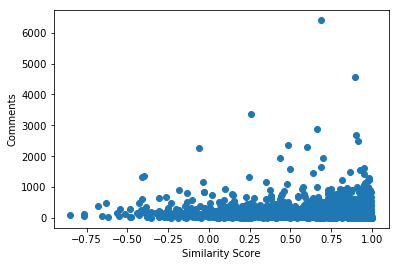

In [30]:
##Scatterplot of similarity scores vs comments
plt.scatter(sim_focused.loc[:,"Similarity Score"],sim_focused.loc[:,"comments"])
plt.xlabel("Similarity Score")
plt.ylabel("Comments")
plt.show()

The above observation applies to views as well. As the similarity scores between words in the titles rises, the view count rises as well.

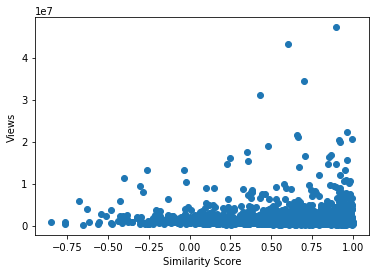

In [31]:
#Scatterplot of similarity scores vs view
plt.scatter(sim_focused.loc[:,"Similarity Score"],sim_focused.loc[:,"views"])
plt.xlabel("Similarity Score")
plt.ylabel("Views")
plt.show()

## What should we keep in mind if we want to make a good TED talk?

Below, I examined the most commonly used words in the TED talks that have the top 10% of views in our set in order to see what the most successful speakers in the past were discussing, or how they were speaking. 

In [33]:
#top10_views
top10_views = ted["views"].quantile(.9)

In [36]:
import os
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
stops=nltk.corpus.stopwords.words("english")
top_10 = ted.loc[ted['views'] > top10_views]

transcripts10= top_10.loc[:, "transcript"]
all_trans = []
for transcript in transcripts10:
    transcript=transcript.lower()
    transcript=re.sub("[^A-Za-z0-9]+"," ",transcript)
    transcript=re.sub("[^\w ]","",transcript)
    transcript=transcript.split(",")
    all_trans.extend(transcript)

titles10= top_10.loc[:, "title"]
all_title10 = []
for title in titles10:
    title=title.lower()
    title=re.sub("[^A-Za-z0-9]+"," ",title)
    title=re.sub("[^\w ]","",title)
    title=title.split(",")
    all_title10.extend(title)
    
all_transcripts10= [word for word in all_trans if word not in stops]
all_transcripts10=str(all_transcripts10)
    
all_titles10= [t for t in all_title10 if t not in stops]
all_titles10=str(all_titles10)

Word Cloud of Transcripts from Top 10


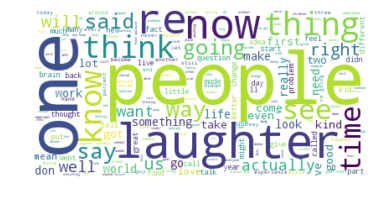

Word Cloud of Top 10th Quantile (by views) Titles


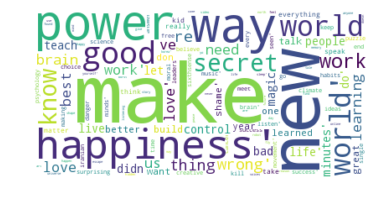

In [39]:
trans_wordcloud10 = WordCloud(background_color='white').generate(all_transcripts10)
plt.figure()
plt.imshow(trans_wordcloud10, interpolation="bilinear")
plt.axis("off")
print('Word Cloud of Transcripts from Top 10')
plt.show()



title_wordcloud10 = WordCloud(background_color='white').generate(all_titles10)
plt.figure()
plt.imshow(title_wordcloud10, interpolation="bilinear")
plt.axis("off")
print('Word Cloud of Top 10th Quantile (by views) Titles')
plt.show()

Another thing that I found to be of importance to the success of a video in terms of views is the video's duration. From the graph below, it is clear that after about 1,500 seconds (25 minutes) the view count of TED talks decreases drastically, and about 20 minutes seems to be a sweet spot. So, if you are planning on creating a successful TED talk, talk about happiness, something new, good, or worldly, and make it short and sweet.

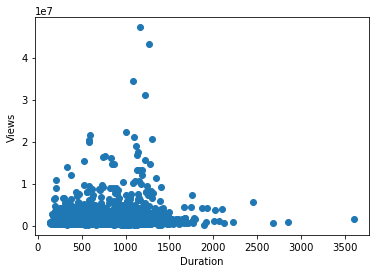

In [40]:
#Scatterplot of duration and views

plt.scatter(ted.loc[:,"duration"],ted.loc[:,"views"])
plt.xlabel("Duration")
plt.ylabel("Views")
plt.show()

Is there a trend in sentiment for specific topics over years? -Valerie

In [7]:
from afinn import Afinn
import matplotlib.pyplot as plt

# this is an example on sentiment analysis
afinn = Afinn(emoticons=True)
print afinn.score('This is utterly excellent!')
print afinn.score('This is utterly bad!')

import pandas as pd

# read in the two csv files
# merge them on the 'url' column into ted.csv
scripts = pd.read_csv("data/transcripts.csv")
ted_main= pd.read_csv("data/ted_main.csv")
ted= pd.merge(scripts, ted_main, on='url')
print len(ted)

# get the column "transcripts" from ted.csv
# print how many talks
transcripts = ted["transcript"]
length = len(transcripts)
print "There are " + str(length) + " talks"

3.0
-3.0
2467
There are 2467 talks


In [8]:
import datetime

unix_film_dates = ted["film_date"]
unix_publish_dates = ted["published_date"]


#function to get sentiment score for a str
def get_senti_score(str):
    score = afinn.score(str)
    return score

#function to get the year
def get_year_film(i):
    film_year=datetime.datetime.fromtimestamp(int(unix_film_dates[i])).strftime('%Y')
    return film_year

In [9]:
import datetime

unix_film_dates = ted["film_date"]
unix_publish_dates = ted["published_date"]

# get list of the readable filmed dates of the talks based on unix timestamp
filmYear=[]
for i in range(0, length):
    real_filmdate=datetime.datetime.fromtimestamp(int(unix_film_dates[i])).strftime('%Y')
    filmYear.append(real_filmdate)

# get list of the readable published dates of the talks based on unix timestamp
publishDate=[]
for i in range(0, 1):
    real_publishdate=datetime.datetime.fromtimestamp(int(unix_publish_dates[i])).strftime('%Y-%m-%d')
    publishDate.append(real_publishdate)

senti_scores=[]
for i in range(0,length):
    score = afinn.score(transcripts[i])
    senti_scores.append(score)


In [10]:
d_year_sentiScore = zip(filmYear, senti_scores)

years_dict = dict()
for i in range(0, len(d_year_sentiScore)):
    year = filmYear[i]
    score = senti_scores[i]
    if year in years_dict:
        # append the new number to the existing array at this slot
        years_dict[year].append(score)
    else:
        # create a new array in this slot
        years_dict[year] = [score]

print years_dict['2004']

[107.0, 161.0, 28.0, 39.0, 209.0, 246.0, 138.0, 85.0, 20.0, 64.0, 68.0, 16.0, 104.0, 201.0, 100.0, 236.0, 103.0, 129.0, 292.0, 334.0, 45.0, 120.0, 194.0, 170.0, 143.0, 106.0, 55.0, 82.0, 52.0, 108.0, 51.0, 185.0]


In [11]:
import collections

years_dict_avg = dict()

for y,s in years_dict.iteritems():
    # v is the list of grades for student k
    years_dict_avg[y] = sum(s)/ float(len(s))    
    

years_dict_avg = collections.OrderedDict(sorted(years_dict_avg.items()))

for keys,values in years_dict_avg.items():
    print(keys + ': ' + str(values))


1984: 121.0
1990: 198.0
1994: 76.0
1998: 95.1666666667
2001: 69.5
2002: 96.962962963
2003: 82.0606060606
2004: 124.71875
2005: 78.9838709677
2006: 87.914893617
2007: 72.2545454545
2008: 71.7875
2009: 63.1735159817
2010: 63.8062015504
2011: 56.1966527197
2012: 51.7969348659
2013: 51.8134328358
2014: 51.0253164557
2015: 48.8577405858
2016: 46.9262295082
2017: 58.4387755102


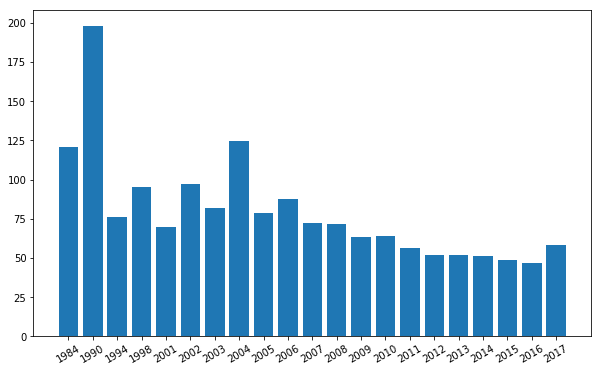

In [12]:
import matplotlib.pyplot as plt

data = years_dict_avg
names = list(data.keys())
values = list(data.values())

#tick_label does the some work as plt.xticks()
plt.figure(figsize=(10,6))
plt.bar(range(len(data)), data.values(), align='center')
plt.xticks(range(len(data)), data.keys(), rotation=30)

plt.show()

In [13]:
from collections import Counter

all_tags = []
for i in range(0, length):
    string_tags = ted['tags'][i].rstrip().replace("'", "")[1:-1].split(',')
    all_tags.append(string_tags)

d_year_tags = zip(filmYear, all_tags)


tags_dict = dict()
for i in range(0, len(d_year_tags)):
    year = filmYear[i]
    tags = all_tags[i]
    if year in tags_dict:
        # append the new number to the existing array at this slot
        tags_dict[year].append(tags)
    else:
        # create a new array in this slot
        tags_dict[year] = [tags]
        
for year, tagsLists in tags_dict.iteritems(): 
    flat_list = []
    for tagsList in tagsLists:
        for tag in tagsList:
            flat_list.append(tag)
    tags_dict[year] = flat_list
        
for year, tagsLists in tags_dict.iteritems(): 
    tags_dict[year] = Counter(tagsLists).most_common(10)
    

print tags_dict.get('2004')

[(' culture', 12), (' entertainment', 10), (' technology', 10), (' design', 7), (' happiness', 7), (' performance', 6), (' psychology', 6), (' science', 6), (' music', 5), ('business', 5)]


In [14]:
from pprint import pprint
pprint(tags_dict)


{'1984': [(' interface design', 1),
          (' entertainment', 1),
          ('demo', 1),
          (' media', 1),
          (' movies', 1),
          (' future', 1),
          (' design', 1),
          (' technology', 1)],
 '1990': [(' collaboration', 1),
          (' technology', 1),
          (' global issues', 1),
          ('architecture', 1),
          (' design', 1)],
 '1994': [(' evolution', 1),
          (' life', 1),
          ('DNA', 1),
          (' genetics', 1),
          (' science', 1),
          (' computers', 1),
          (' TED Brain Trust', 1),
          (' programming', 1),
          (' history', 1),
          (' future', 1)],
 '1998': [(' technology', 5),
          (' design', 4),
          (' culture', 2),
          (' solar energy', 1),
          (' faith', 1),
          ('art', 1),
          (' science', 1),
          ('demo', 1),
          (' prosthetics', 1),
          ('Christianity', 1)],
 '2001': [('culture', 2),
          (' poetry', 2),
          ('ar

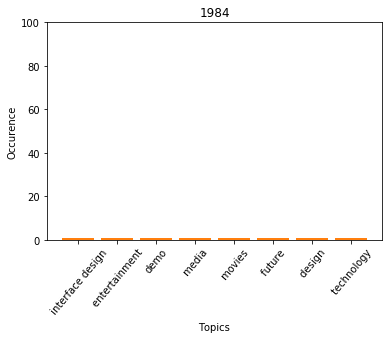

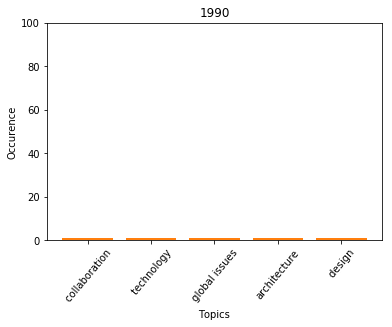

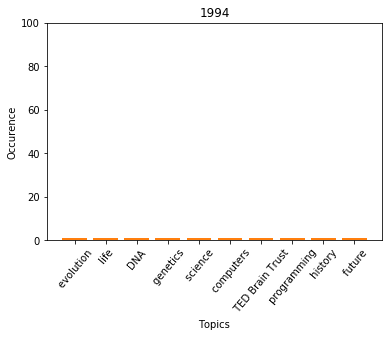

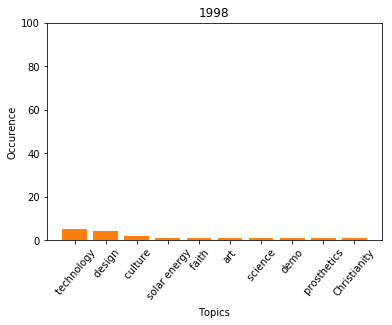

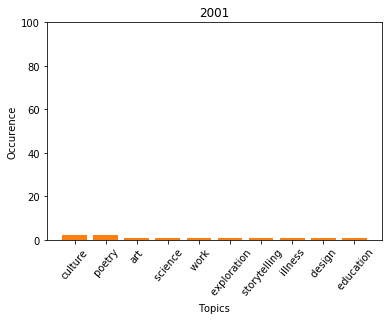

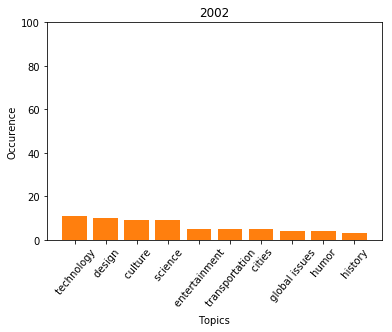

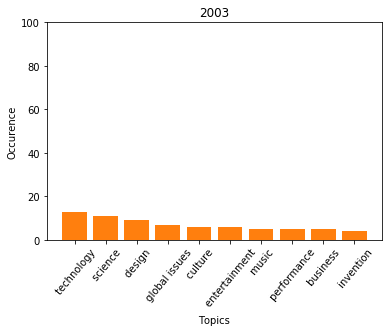

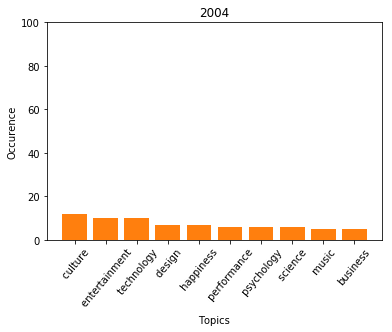

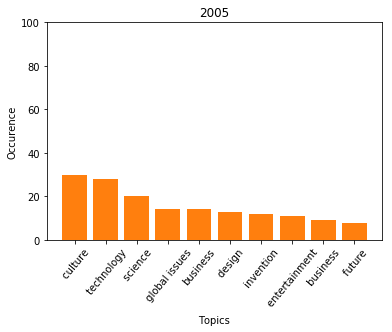

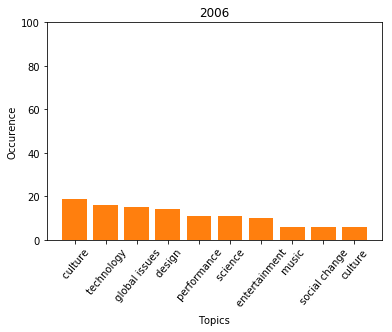

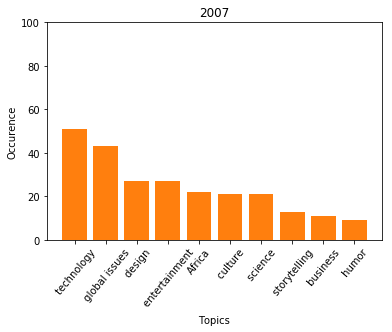

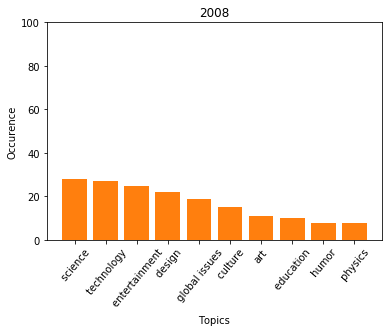

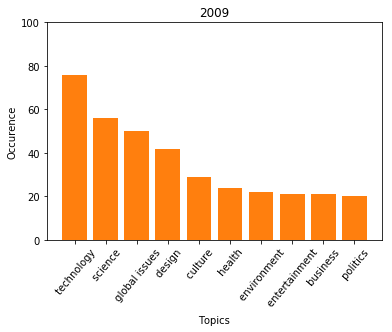

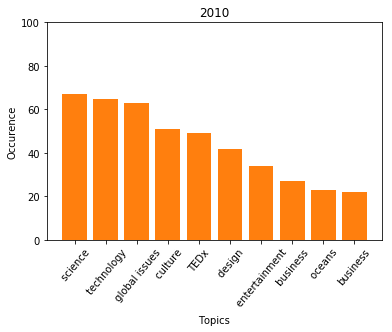

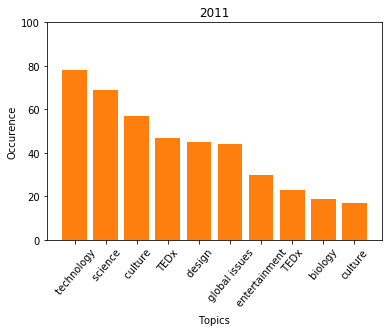

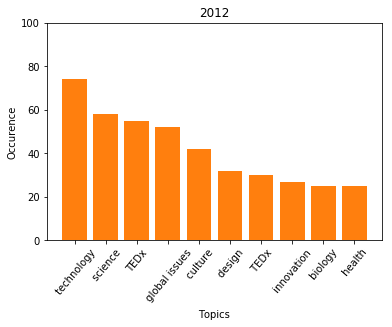

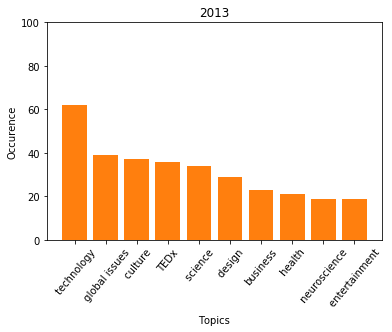

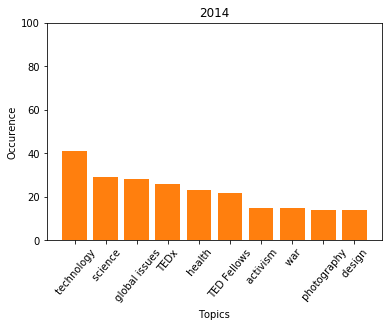

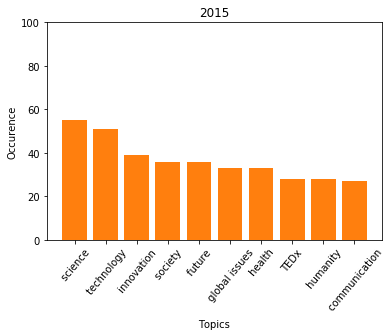

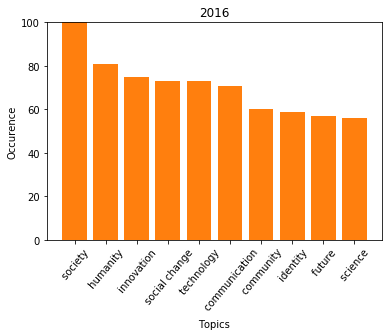

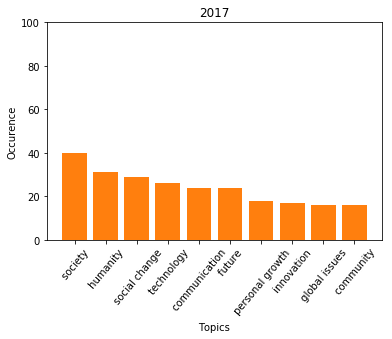

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

od = collections.OrderedDict(sorted(tags_dict.items()))
tagData = od

for year, values in tagData.iteritems():
    tags_counter = zip(*values)   
    X = list(tags_counter[0])
    Y = list(tags_counter[1])
    plt.bar(X,Y)   
    plt.xlabel('Topics')
    plt.ylabel('Occurence')
    plt.title(str(year))
    plt.bar(*tags_counter)
    plt.xticks(range(len(Y)),rotation=50)
    plt.ylim(0, 100)
    plt.show()


